In [2]:
from models import *
from utils import *
import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import glob
import pandas as pd

plt.style.use('seaborn-whitegrid')
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

categories_in_data = ['bicycle', 'phone', 'helmet', 'airbag_helmet']
categories_lookup = dict(zip(categories_in_data, range(len(categories_in_data))))

### Load Models

In [3]:
config_path='config/yolov3.cfg'
class_path='config/coco.names'
img_size=416

# Load Models and Weights

## bicycle
weights_path_bicycle='checkpoints/bicycle/bicycle.weights'
conf_thres_bicycle=0.9
nms_thres_bicycle=0.2

model_bicycle = Darknet(config_path, img_size=img_size)
model_bicycle.load_weights(weights_path_bicycle)
if torch.cuda.is_available():
  model_bicycle.cuda()
model_bicycle.eval()

## helmet
weights_path_helmet='checkpoints/helmet/90.weights'
conf_thres_helmet=0.8
nms_thres_helmet=0.2

model_helmet = Darknet(config_path, img_size=img_size)
model_helmet.load_weights(weights_path_helmet)
if torch.cuda.is_available():
  model_helmet.cuda()
model_helmet.eval()

classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

/zhome/79/4/146412/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


### Make Predictions

In [3]:
def detect_image(model, conf_thres, nms_thres, img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms=transforms.Compose([transforms.Resize((imh,imw)),
         transforms.Pad((max(int((imh-imw)/2),0), 
              max(int((imw-imh)/2),0), max(int((imh-imw)/2),0),
              max(int((imw-imh)/2),0)), (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, 
                        conf_thres, nms_thres)
    return detections[0]

In [4]:
# load image and get detections
directories_to_look_in = ["data/helmet/", "data/bicycle/"]
class_count = {}
plot = False
save = False

img_paths = []
for dir in directories_to_look_in:
    with open(dir + "val.txt") as t:
        lines = t.readlines()
    img_paths = [line.replace("\n", "") for line in lines]
    img_paths += img_paths
    img_paths = list(np.unique(img_paths))

In [564]:


count = 0
for img_path in img_paths:
  update_progress(count / len(img_paths))
  save_detections = np.array([])
  class_count["_".join(img_path.split("/")[-1].split("_")[:2])] = {}
  # get ground_truth classes 
  img_gt_classes = []
  for dir in directories_to_look_in:
    for labelfile in glob.glob(dir + "labels/" + "_".join(img_path.split("/")[-1].split("_")[:2]) + "_*.txt"):
        with open(labelfile) as t:
            data = t.readlines()
            img_gt_classes.append(int(data[0][0]))
  class_count["_".join(img_path.split("/")[-1].split("_")[:2])]['gt'] = img_gt_classes

  prev_time = time.time()
  img = Image.open(img_path)
  
  detections_bicycle =  detect_image(model_bicycle, conf_thres_bicycle, nms_thres_bicycle, img)
  detections_helmet =  detect_image(model_helmet, conf_thres_helmet, nms_thres_helmet, img)
  
  
  det_list = []
  for det in [detections_helmet, detections_bicycle]:
    if det != None:
      det_list.append(det)
  try:
    detections = torch.cat(det_list)
  except:
    detections = None

  inference_time = datetime.timedelta(seconds=time.time() - prev_time)

  #print ('Inference Time: %s' % (inference_time))
  # Get bounding-box colors
  bbox_colors = {'bicycle': 'k', 'helmet': 'b', 'phone': 'r', 'airbag_helmet': 'g'}
  img = np.array(img)
  if plot:
    plt.figure()
    fig, ax = plt.subplots(1, figsize=(12,9))
    ax.imshow(img)
  pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
  pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
  unpad_h = img_size - pad_y
  unpad_w = img_size - pad_x
  if detections is not None:
      unique_labels = detections[:, -1].cpu().unique()
      n_cls_preds = len(unique_labels)
      # browse detections and draw bounding boxes
      img_pred_classes = []
      with open("val_predictions/" + img_path.split("/")[-1].split(".")[0] + ".txt", "w+") as f:
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
            img_pred_classes.append(int(cls_pred)) # for stats

            box_h = ((y2 - y1) / unpad_h) * img.shape[0]
            box_w = ((x2 - x1) / unpad_w) * img.shape[1]
            if classes[int(cls_pred)] == 'bicycle':  
              y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0] + box_h/2 # trained model with corner xy instead of middle
              x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1] + box_w/2 # trained model with corner xy instead of middle
            else:
              y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
              x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
            color = bbox_colors[classes[int(cls_pred)]]
            if plot:
              bbox = patches.Rectangle((x1, y1), box_w, box_h,
                  linewidth=2, edgecolor=color, facecolor='none')
              ax.add_patch(bbox)
              plt.text(x1, y1, s=classes[int(cls_pred)], 
                    color='white', verticalalignment='top',
                    bbox={'color': color, 'pad': 0})

            save_detections = np.append(save_detections, np.array([i.item() for i in [cls_pred, x1 + box_w/2, y1 + box_h/2, box_w, box_h]]))
            f.write(f"{cls_pred.item()} {cls_conf.item()} {(x1 + box_w/2).item()} {(y1 + box_h/2).item()} {box_w.item()} {box_h.item()}\n" )

      class_count["_".join(img_path.split("/")[-1].split("_")[:2])]['pred'] = img_pred_classes
  save_detections = save_detections.reshape((save_detections.size // 5, 5))
  if plot:
    plt.axis('off')
  # save image
  if plot:
    if save:
      plt.savefig(img_path.replace(".jpg", "-det.jpg"),        
                        bbox_inches='tight', pad_inches=0.0)
    plt.show()
  count += 1
if not plot:
  update_progress(1)


Progress: [####################] 100.0%


### Mean Average Precision

In [5]:
def get_gt_boxes(image_name, class_name):

    og_labels = np.array([])

    W = 1440
    H = 1920
    for i in glob.glob(f'data/{class_name}/labels/{image_name}*.txt'):
        with open(i) as t:
            data = t.readlines()
            output = [float(a) for a in data[0].split(" ")]
            output[1] = output[1] * W
            output[2] = output[2] * H
            output[3] = output[3] * W
            output[4] = output[4] * H

        og_labels = np.append(og_labels, np.array(output).reshape((5,1)))
    og_labels = og_labels.reshape((og_labels.size // 5, 5))
    return og_labels[:, 1:]

In [6]:
def get_pred_boxes(image_name, class_name):

    with open(f"val_predictions/{image_name}.txt") as t:
        lines = t.readlines()

    lines = [line.replace("\n", "") for line in lines]
    lines = [[float(a) for a in line.split(" ")] for line in lines]

    pred_boxes = np.array([])
    for line in lines:
        if line[0] == float(categories_lookup[class_name]):
            pred_boxes = np.append(pred_boxes, np.array(line))
        else:
            pass
    if len(pred_boxes) == 0:
        return np.array([]), np.array([])
    else:
        pred_boxes = pred_boxes.reshape((pred_boxes.size // 6, 6))
        return pred_boxes[:, 2:], pred_boxes[:, 1] # box coords and class confidence

        
        

#### Class: bicycle

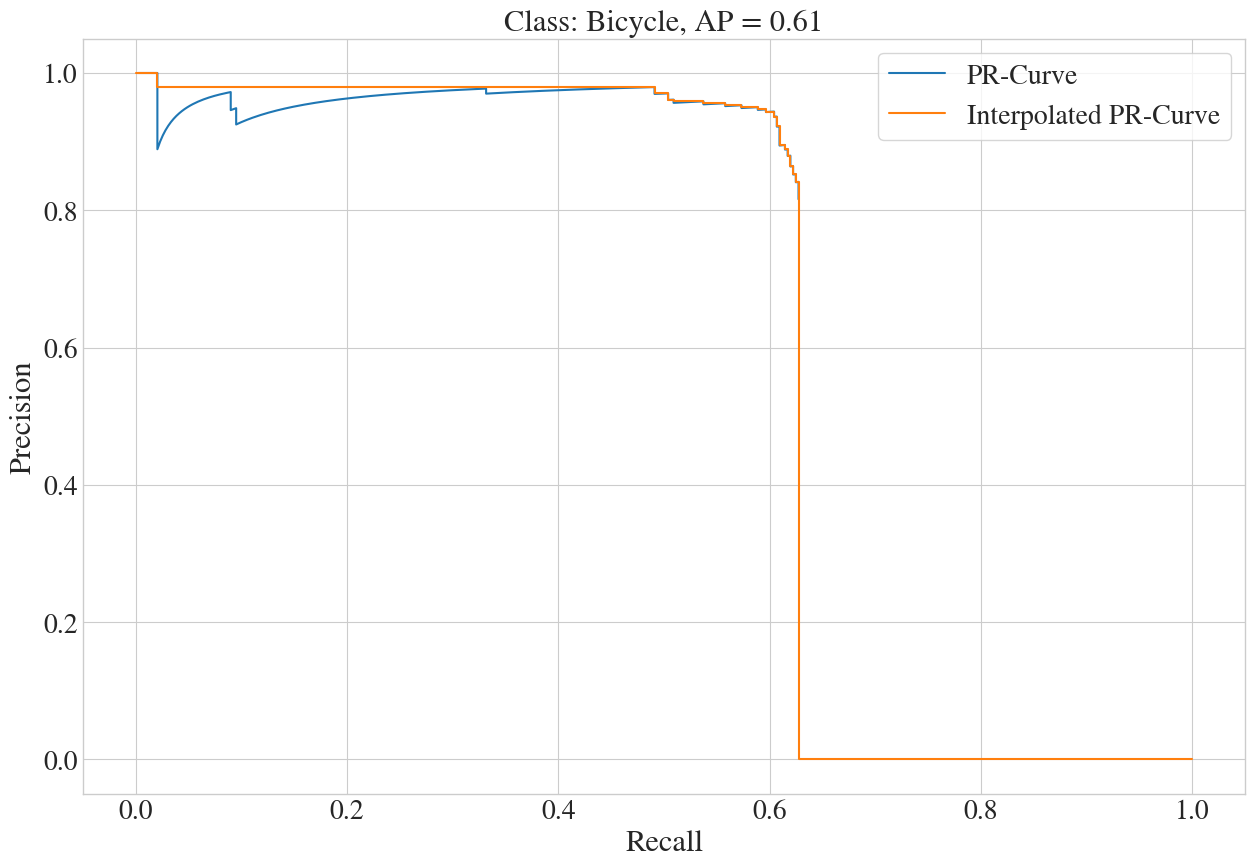

In [56]:
class_name = 'bicycle'

names = [name.split("/")[-1].split(".")[0] for name in img_paths]
n_gt_boxes = 0
n_pred_boxes = 0


IMAGE_IDS = np.array([])
PRED_IDS = np.array([])
CLASS_CONFS = np.array([])

TP = np.array([])
FP = np.array([])

pred_id = 0
for name in names:
    gt_boxes = get_gt_boxes(name[:-2], class_name)
    pred_boxes, cls_confs = get_pred_boxes(name, class_name)

    IMAGE_IDS = np.append(IMAGE_IDS, np.repeat(name, len(pred_boxes)))
    CLASS_CONFS = np.append(CLASS_CONFS, cls_confs)

    local_pred_id = np.array([])
    for pred in pred_boxes:
        pred_ious = np.array([])

        for gt in gt_boxes:
            iou = utils.bbox_iou(torch.from_numpy(gt).view(1,4),
                    torch.from_numpy(pred).view(1,4),
                    False
                    ).item()
            pred_ious = np.append(pred_ious, iou)
            
        #print(pred_ious)
        if np.max(pred_ious) >= 0.5:
            TP = np.append(TP, 1.0)
            FP = np.append(FP, 0.0)
        else:
            TP = np.append(TP, 0.0)
            FP = np.append(FP, 1.0)


        local_pred_id = np.append(local_pred_id, pred_id)
        pred_id += 1

    
    n_gt_boxes += len(gt_boxes)
    n_pred_boxes += len(pred_boxes)

    PRED_IDS = np.append(PRED_IDS, local_pred_id)

    assert len(TP) == len(FP) == len(IMAGE_IDS) == len(PRED_IDS) == len(CLASS_CONFS), 'Dimension Error'

pr = pd.DataFrame(
    {
        'image_id': IMAGE_IDS,
        'pred_id': PRED_IDS,
        'cls_conf': CLASS_CONFS,
        'TP': TP,
        'FP': FP
    }
)

pr = pr.sort_values('cls_conf', ascending = False).reset_index(drop = True)
pr['acc_TP'] = np.cumsum(pr.TP)
pr['acc_FP'] = np.cumsum(pr.FP)
pr['precision'] = pr.acc_TP/(pr.acc_TP + pr.acc_FP)
pr['recall'] = pr.acc_TP/n_gt_boxes

ap_bicycle, interp_recall, interp_precision = utils.compute_ap(pr.recall, pr.precision)


plt.figure(figsize = (15,10), dpi = 100)
plt.plot(pr.recall, pr.precision, label = 'PR-Curve')
plt.step(interp_recall, interp_precision, label = 'Interpolated PR-Curve')
plt.title(f'Class: Bicycle, AP = {round(ap_bicycle,4)}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(frameon = True)
plt.savefig('plots/bicycle_pr.png', bbox_inches = 'tight')
plt.show()

    
    
    

#### Class: helmet

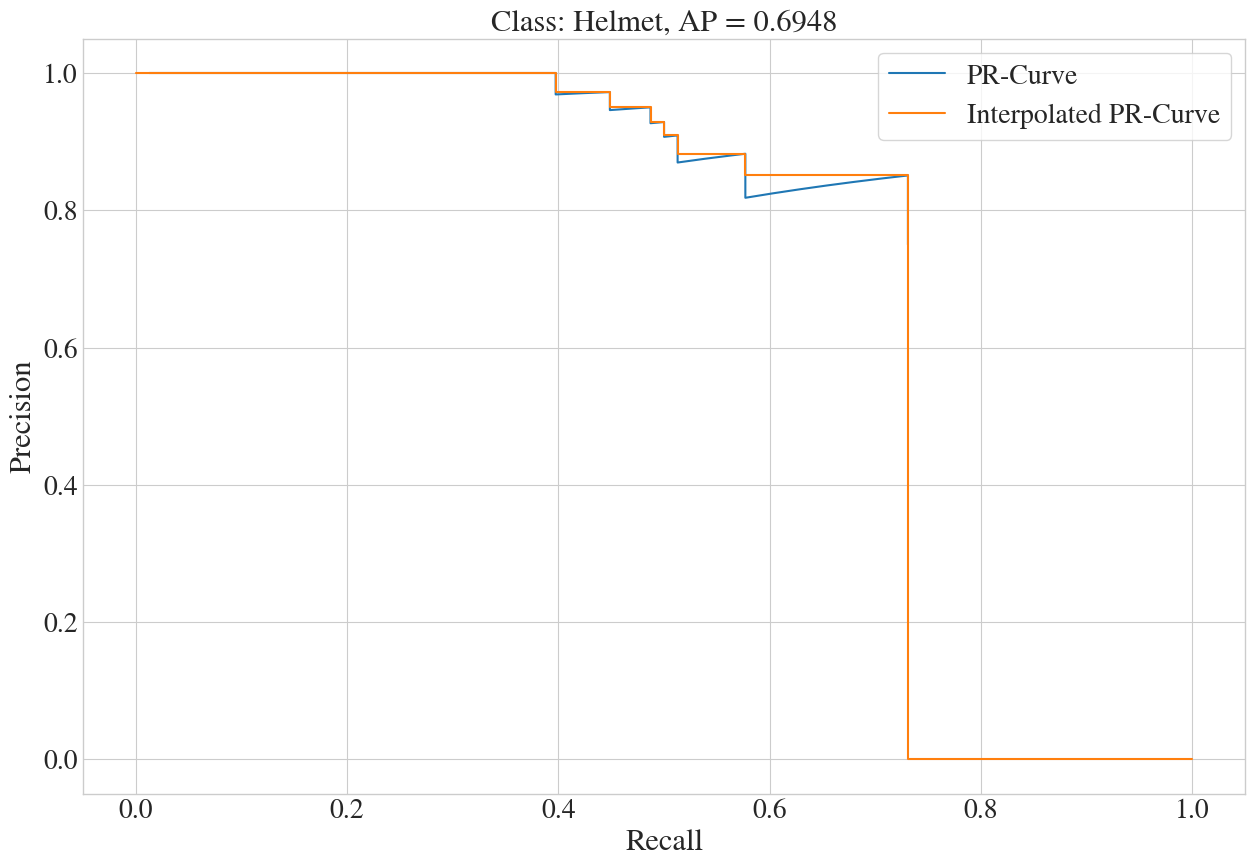

In [15]:
class_name = 'helmet'
names = [name.split("/")[-1].split(".")[0] for name in img_paths]
n_gt_boxes = 0
n_pred_boxes = 0


IMAGE_IDS = np.array([])
PRED_IDS = np.array([])
CLASS_CONFS = np.array([])

TP = np.array([])
FP = np.array([])

pred_id = 0
for name in names:
    gt_boxes = get_gt_boxes(name[:-2], class_name)
    pred_boxes, cls_confs = get_pred_boxes(name, class_name)

    IMAGE_IDS = np.append(IMAGE_IDS, np.repeat(name, len(pred_boxes)))
    CLASS_CONFS = np.append(CLASS_CONFS, cls_confs)

    local_pred_id = np.array([])
    for pred in pred_boxes:
        pred_ious = np.array([])

        for gt in gt_boxes:
            iou = utils.bbox_iou(torch.from_numpy(gt).view(1,4),
                    torch.from_numpy(pred).view(1,4),
                    False
                    ).item()
            pred_ious = np.append(pred_ious, iou)
            
        #print(pred_ious)
        if len(pred_ious) == 0:
            TP = np.append(TP, 0.0)
            FP = np.append(FP, 0.0)
        elif np.max(pred_ious) >= 0.5:
            TP = np.append(TP, 1.0)
            FP = np.append(FP, 0.0)
        else:
            TP = np.append(TP, 0.0)
            FP = np.append(FP, 1.0)


        local_pred_id = np.append(local_pred_id, pred_id)
        pred_id += 1

    
    n_gt_boxes += len(gt_boxes)
    n_pred_boxes += len(pred_boxes)

    PRED_IDS = np.append(PRED_IDS, local_pred_id)

    assert len(TP) == len(FP) , 'Dimension Error'

    
pr = pd.DataFrame(
    {
        'image_id': IMAGE_IDS,
        'pred_id': PRED_IDS,
        'cls_conf': CLASS_CONFS,
        'TP': TP,
        'FP': FP
    }
)

pr = pr.sort_values('cls_conf', ascending = False).reset_index(drop = True)
pr['acc_TP'] = np.cumsum(pr.TP)
pr['acc_FP'] = np.cumsum(pr.FP)
pr['precision'] = pr.acc_TP/(pr.acc_TP + pr.acc_FP)
pr['recall'] = pr.acc_TP/n_gt_boxes


ap_helmet, interp_recall, interp_precision = utils.compute_ap(pr.recall, pr.precision)

plt.figure(figsize = (15,10), dpi = 100)
plt.plot(pr.recall, pr.precision, label = 'PR-Curve')
plt.step(interp_recall, interp_precision, label = 'Interpolated PR-Curve')
plt.title(f'Class: Helmet, AP = {round(ap_helmet,4)}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(frameon = True)
plt.savefig('plots/helmet_pr.png', bbox_inches = 'tight')
plt.show()
    
    

In [14]:
mAP = (ap_bicycle + ap_helmet)/2
mAP

0.6524061291878132

### Count

In [75]:
n_bicycles_gt = []
n_helmets_gt = []

n_bicycles_pred = []
n_helmets_pred = []

for name in names:
    gt_bicycles = get_gt_boxes(name[:-2], 'bicycle')
    pred_bicycles, _ = get_pred_boxes(name, 'bicycle')


    gt_helmets = get_gt_boxes(name[:-2], 'helmet')
    pred_helmets, _ = get_pred_boxes(name, 'helmet')


    n_bicycles_gt.append(len(gt_bicycles))
    n_helmets_gt.append(len(gt_helmets))

    n_bicycles_pred.append(len(pred_bicycles))
    n_helmets_pred.append(len(pred_helmets))

print('Bicycle:')
print(f'\tGround Truth: {np.sum(n_bicycles_gt)}')
print(f'\tPredictions: {np.sum(n_bicycles_pred)}')
print()
print('Helmets:')
print(f'\tGround Truth: {np.sum(n_helmets_gt)}')
print(f'\tPredictions: {np.sum(n_helmets_pred)}')

Bicycle:
	Ground Truth: 389
	Predictions: 299

Helmets:
	Ground Truth: 78
	Predictions: 187


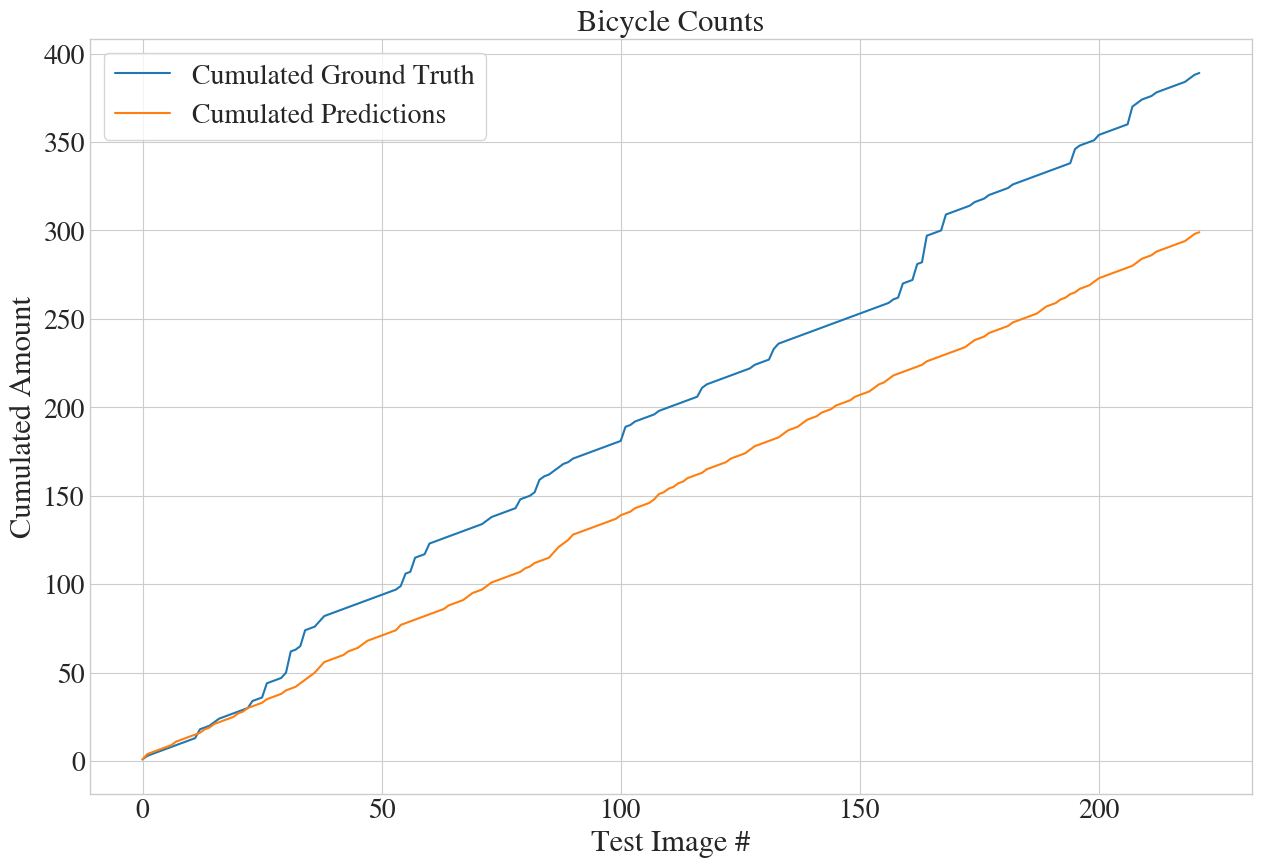

In [76]:
plt.figure(figsize = (15,10), dpi = 100)
plt.plot(range(len(names)), np.cumsum(n_bicycles_gt), label = 'Cumulated Ground Truth')
plt.plot(range(len(names)), np.cumsum(n_bicycles_pred), label = 'Cumulated Predictions')
plt.xlabel('Test Image #')
plt.ylabel('Cumulated Amount')
plt.legend(frameon = True)
plt.title('Bicycle Counts')
plt.savefig('plots/bicycle_counts.png', bbox_inches = 'tight')
plt.show()

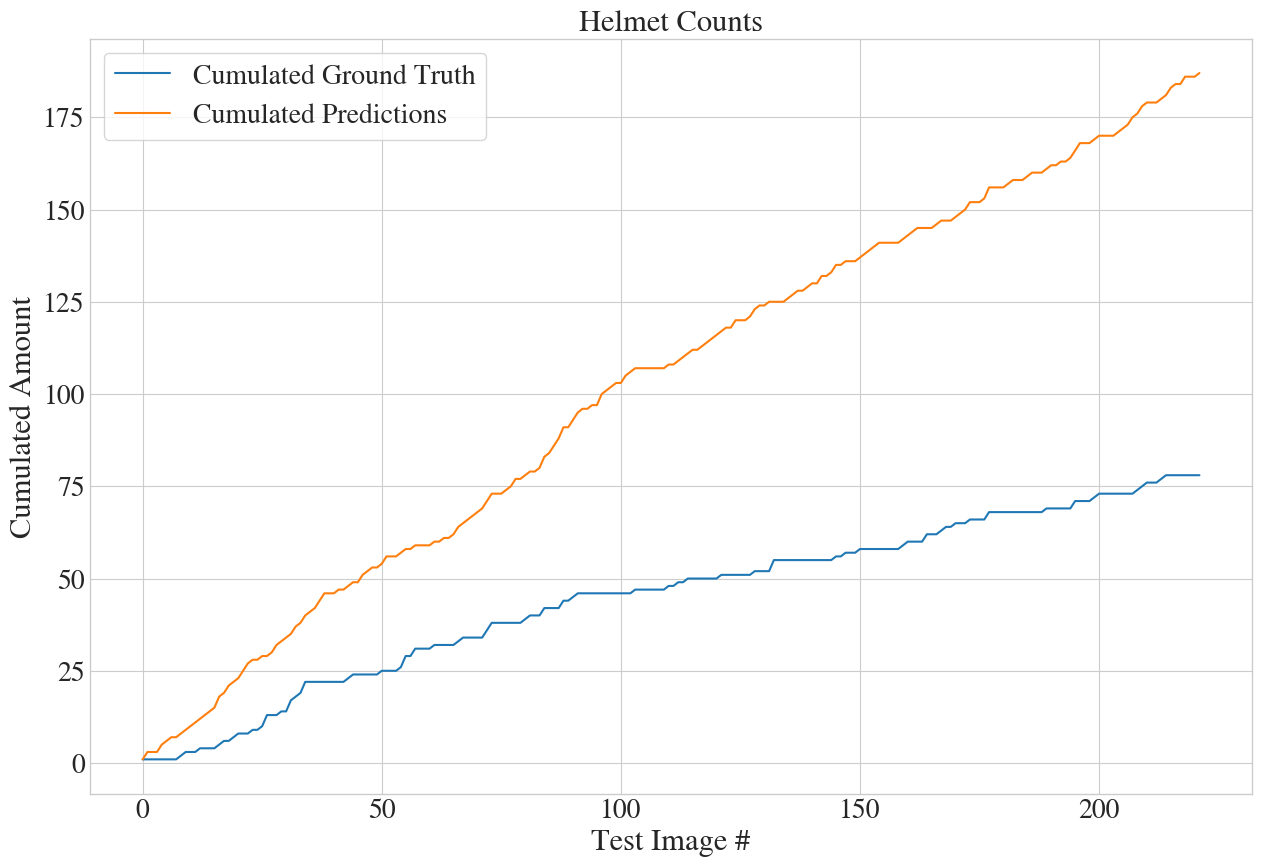

In [77]:
plt.figure(figsize = (15,10), dpi = 100)
plt.plot(range(len(names)), np.cumsum(n_helmets_gt), label = 'Cumulated Ground Truth')
plt.plot(range(len(names)), np.cumsum(n_helmets_pred), label = 'Cumulated Predictions')
plt.xlabel('Test Image #')
plt.ylabel('Cumulated Amount')
plt.legend(frameon = True)
plt.title('Helmet Counts')
plt.savefig('plots/helmet_counts.png', bbox_inches = 'tight')
plt.show()